<a href="https://colab.research.google.com/github/rudra404/NLP-RNN-Emotions-Classification/blob/main/GoEmotions_initial_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoEmotions Initial Experimentation
In this notebook, some initial experimentaation is carried out to determine feasible values for various parameters in the pipeline. This is additional to the 4 experiments

### Set up steps for notebook
Required packages and dependencies are installed with compatible versions and the notebook is set up to use GPU when available.

In [ ]:
# Install datasets
!pip install datasets

# Install dependencies
%pip install torch==1.11.0+cu113 torchdata==0.3.0 torchtext==0.12.0 -f https://download.pytorch.org/whl/cu113/torch_stable.html
%pip install spacy tqdm
!python -m spacy download en_core_web_sm

# Initialise torch and use GPU
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 1.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


Use this cell to mount your Google Drive on the notebook. Some files in the zip folder are used to reduce repeating of some setup steps.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---



---



---

## Baseline Experiment using default parameters



---


### Data Preprocessing


---



Converting the dataset to a dataframe and **duplicating any records that have multiple labels** so that each datapoint has 1 label.

In [ ]:
from datasets import load_dataset
import pandas as pd

# load the GoEmotions dataset
goemotions_dataset = load_dataset('go_emotions')

# get the train, validation, and test splits as Pandas dataframes
train_df = goemotions_dataset['train'].to_pandas()
val_df = goemotions_dataset['validation'].to_pandas()
test_df = goemotions_dataset['test'].to_pandas()

# concatenate the splits into a single dataframe
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# duplicate the records with multiple labels
df = df.explode('labels')

# reset the index of the dataframe
df = df.reset_index(drop=True)

# print the first five rows of the resulting dataframe
print(df.head())


Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

                                                text labels       id
0  My favourite food is anything I didn't have to...     27  eebbqej
1  Now if he does off himself, everyone will thin...     27  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING      2  eezlygj
3                        To make her feel threatened     14  ed7ypvh
4                             Dirty Southern Wankers      3  ed0bdzj


Merging some of the labels according to published academic research relating emotions to one another and as per the correlation values of the labels in the original dataset [REFERENCE ORIGINAL GOEMOTIONS RESEARCH PAPER HERE]. Dropping the remaining instances where labels are not used. Also dropping instances where text is repeated with different label values.<br>
Also converting to a map-style dataset as pytorch provides the data in an iterable-style format. This needs to be done for further processing and using the data.

In [ ]:
from torchtext.data.functional import to_map_style_dataset

### MERGING EMOTION LABELS FROM GROUP DECISIONS ###

for i, row in df.iterrows():
  # Converting Annoyance [3] into Anger [2]
  if row['labels']==3:
    row['labels']=2
  # Disappointment [9] and Grief [16] into Sadness [25]
  if row['labels']==9 or row['labels']==16:
    row['labels']=25
  # Converting Nervousness [19] into Fear [14]
  if row['labels']==19:
    row['labels']=14
  # Converting Excitement [13] into Joy [17]
  if row['labels']==13:
    row['labels']=17

#keeps just one of the records where there are labelled with both merged classes
df = df.drop_duplicates(keep = 'first')
drop_labels = (3,11,12,9,16,19,22,26,21,13,0,23,20,5)
#drops labels we are not using
df_cut = df[~df.labels.isin(drop_labels)]
#deletes duplicates
df_cut = df_cut.drop_duplicates(subset = ['text'], keep = False)
df_cut = df_cut.reset_index(drop = True)

### REORDERING SO THAT LABELS ARE 0-13 ###
for i, row in df_cut.iterrows():
    # Converting Neutral [27] to Neutral [0]
    if row['labels']==27:
        row['labels']=0
    # Converting Sadness [25] to Sadness [3]
    if row['labels']==25:
        row['labels']=3
    # Converting Remorse [24] to Remorse [5]
    if row['labels']==24:
        row['labels']=5
    # Converting Love [18] to Love [9]
    if row['labels']==18:
        row['labels']=9
    # Converting Fear [14] to Fear [11]
    if row['labels']==14:
        row['labels']=11
    # Converting Gratitude [15] to Gratitude [12]
    if row['labels']==15:
        row['labels']=12
    # Converting Joy [17] to Joy [13]
    if row['labels']==17:
        row['labels']=13

df = df_cut
# reset the index of the dataframe
df = df.reset_index(drop=True)
df.head()

# convert dataframe to list
text = df[['text','labels']].values.tolist()

# convert the dataset into a "map-style dataset"
data = to_map_style_dataset(text)

So now only the chosen labels remain and they are ordered from 0-13 (expected by pyTorch at a later stage).<br>
<br>
We also save the dataset at this point so it can be reused for the remaining experiments (which may be in a different notebook)

In [ ]:
if __name__ == '__main__':
  torch.save(text, "preprocessed_data_1.pt")

In [ ]:
text = torch.load("/content/drive/MyDrive/Colab Notebooks/NLP CW/preprocessed_data_1.pt")
data = to_map_style_dataset(text)
data[0]

["My favourite food is anything I didn't have to cook myself.", 0]

Splitting the dataset into train, test, and validation sets

In [ ]:
from torch.utils.data import random_split

split_ratio = 0.7  # 70/30 split

# split dataset into train and test sets
train_samples = int(split_ratio * len(data))
test_samples = len(data) - train_samples
train_data, test_data = random_split(data, [train_samples, test_samples])

# split train subset into train and validation sets
train_samples = int(split_ratio * len(train_data))
valid_samples = len(train_data) - train_samples
train_data, valid_data = random_split(train_data, [train_samples, valid_samples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 20153
Number of validation examples: 8638
Number of testing examples: 12340


Tokenizing the data and building vocabularies

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, vocab
from collections import OrderedDict

import torchtext.transforms as T

# defining a tokenizer as a PyTorch module
class SpacyTokenizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

    def forward(self, input):
        if isinstance(input, list):
            tokens = []
            for text in input:
                tokens.append(self.tokenizer(text))
            return tokens
        elif isinstance(input, str):
            return self.tokenizer(input)
        raise ValueError(f"Type {type(input)} is not supported.")

# defining auxilary functions for tokenizing

tokenizer = SpacyTokenizer()
MAX_VOCAB_SIZE = 25_000

def _process_texts_for_vocab(data):
    for line in data:
        yield tokenizer(line[0])

def _get_labels_for_vocab(data):
    for line in data:
        yield [line[1]]

# defining a function to transform each text into its length
class ToLengths(torch.nn.Module):
    def forward(self, input):
        if isinstance(input[1], list):    # changed to match the order in dataset
            lengths = []
            for text in input:
                lengths.append(len(text))
            return lengths
        elif isinstance(input, list):
            return len(input)
        raise ValueError(f"Type {type(input)} is not supported.")

In [ ]:
# tokenizing text and label vocabs
text_vocab = build_vocab_from_iterator(_process_texts_for_vocab(train_data), specials=('<unk>', '<pad>'), max_tokens=MAX_VOCAB_SIZE)
label_vocab = vocab(OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)]))
text_vocab.set_default_index(text_vocab["<unk>"])

In [ ]:
# saving the vocabularies for future use
if __name__ == '__main__':
  torch.save(text_vocab, "text_vocab.pt")
  torch.save(label_vocab, "label_vocab.pt")

In [ ]:
text_vocab = torch.load("text_vocab.pt")
label_vocab = torch.load("label_vocab.pt")

Make sure everything is in order after performing previous steps:

In [ ]:
# check the tokens in text and label vocabulary
print(f"Unique tokens in text vocabulary: {len(text_vocab)}")
print(f"Unique tokens in label vocabulary: {len(label_vocab)}")

Unique tokens in text vocabulary: 22695
Unique tokens in label vocabulary: 14


In [ ]:
# check the items in each vocabulary
# text_vocab.get_itos()[:10]
# label_vocab.get_stoi()
# label_vocab.get_itos()

{'joy': 13,
 'amusement': 1,
 'neutral': 0,
 'anger': 2,
 'sadness': 3,
 'approval': 4,
 'remorse': 5,
 'curiosity': 7,
 'confusion': 6,
 'love': 9,
 'disapproval': 10,
 'gratitude': 12,
 'desire': 8,
 'fear': 11}

In [ ]:
# view most frequent words in the vocabulary
from collections import Counter

counter = Counter()
for (line, label) in train_data:
    counter.update(tokenizer(line))

counter.most_common(20)

[('.', 16890),
 ('I', 8855),
 ('the', 7585),
 (',', 6511),
 ('to', 5852),
 ('a', 5593),
 ('you', 4253),
 ('and', 3925),
 ('it', 3905),
 ('is', 3878),
 ('!', 3822),
 ('that', 3734),
 (']', 3717),
 ('[', 3707),
 ('NAME', 3635),
 ('of', 3268),
 ('in', 2637),
 ('for', 2597),
 ('?', 2576),
 ('this', 2278)]

To use the required texts, labels, and lengths in an RNN with pytorch, we need to convert them to the required tensor format. This is done slightly differently for each.

In [ ]:
# convert texts, labels, and lengths into tensors appropriately

text_transform = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    T.ToTensor(),  # Convert to tensor
)

lengths_transform = T.Sequential(
    SpacyTokenizer(),   # tokenize
    ToLengths(),    # convert to lengths
    T.ToTensor(),   # convert to tensor
)

In [ ]:
# check if the pipeline works as expected by testing a sample

# sample_text, sample_label = train_data[0]

# print(f"Text before any processing: {sample_text}")
# print(f"Label before any processing: {sample_label}\n")

# # Text Processing Pipeline
# tokenizer = SpacyTokenizer()
# sample_text = tokenizer(sample_text)
# print(f"Text after Tokenizer: {sample_text}\n")

# vocab_transform = T.VocabTransform(text_vocab)
# sample_text = vocab_transform(sample_text)
# print(f"Text after Vocab Transform: {sample_text}\n")

# tensor_transform = T.ToTensor(padding_value=text_vocab["<pad>"])
# sample_text = tensor_transform(sample_text)
# print(f"Text after Tensor Transform: {sample_text}\n")

# # Label Processing Pipeline
# print(f"Label after label transform: {label_transform([sample_label])}\n")

# Length Processing Pipeline
# print(f"Text after length transform: {lengths_transform([train_data[0][0]])}") # changed to match order of texts and labels

Text before any processing: [NAME] had more of a Pro Bowl season than [NAME].
Label before any processing: 0

Text after Tokenizer: ['[', 'NAME', ']', 'had', 'more', 'of', 'a', 'Pro', 'Bowl', 'season', 'than', '[', 'NAME', ']', '.']

Text after Vocab Transform: [15, 16, 14, 104, 74, 17, 7, 7290, 3600, 365, 105, 15, 16, 14, 2]

Text after Tensor Transform: tensor([  15,   16,   14,  104,   74,   17,    7, 7290, 3600,  365,  105,   15,
          16,   14,    2])

Label after label transform: tensor([0])



Define dataloader for pytorch and load the train, test, and validation sets

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

def collate_batch(batch):
    texts, labels = zip(*batch)

    lengths = lengths_transform(list(texts))
    texts = text_transform(list(texts))
    labels = torch.tensor(list(labels), dtype=torch.int64)

    return labels.to(DEVICE), texts.to(DEVICE), lengths.cpu()


def _get_dataloader(data):
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)


In [ ]:
train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

---
### Functions required for training and evaluation
---

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
import time

# defining a function for training the model
# Taken from lab but changed to be used for multi-class classification training instead of binary classification

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in tqdm(iterator, desc="\tTraining"):
        optimizer.zero_grad()

        labels, texts, lengths = batch  # Note that this has to match the order in collate_batch
        predictions = model(texts, lengths)
        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Defining a function to evaluate using the trained model (on either validation or test sets)
# Taken from lab 5 but changed to be used for multi-class classification evaluation instead of binary classification
# Further modified to return metrics like F1 score, confusion matrix, and classification report to check scores for each class
# ChatGPT was used for debugging aur_roc code

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    predicted_probs = []
    true_labels = []

    model.eval()

    with torch.no_grad():
        for batch in tqdm(iterator, desc="\tEvaluation"):
            labels, texts, lengths = batch  # Note that this has to match the order in collate_batch
            predictions = model(texts, lengths)
            probs = torch.softmax(predictions, dim=1)
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            predicted_probs.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predicted_probs = np.array(predicted_probs)
    true_labels = np.array(true_labels)
    predicted_labels = np.argmax(predicted_probs, axis=1)

    epoch_f1 = f1_score(true_labels, predicted_labels, average='weighted')
    epoch_auc_roc = roc_auc_score(true_labels, predicted_probs, multi_class='ovo', average='weighted')
    epoch_classification_report = classification_report(true_labels, predicted_labels)
    epoch_confusion_matrix = confusion_matrix(true_labels, predicted_labels)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1, epoch_auc_roc, epoch_classification_report, epoch_confusion_matrix


# defining a function to check duration taken for training and testing
# taken from lab 5

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


#defining a function to check number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# defining a categorical accuracy function instead of binary accuracy
# ChatGPT was used to find this piece of code and further debugging was required to make it work as expected

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc



---

### Model Building

---



Using basic RNN provided in lab 6 [REFERENCE LAB 6 HERE] as a baseline model for comparison of performance after changing some parameters

In [ ]:
import torch.nn as nn

# Define an RNN class
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM) # create a RNN model using the arguments
print(f'The model has {count_parameters(model):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 2,364,746 trainable parameters


Training the model in epochs and saving the one with the lowest validation loss

In [ ]:
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'baseline-model.pt')

Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:08<00:00, 36.00it/s]


	Train Loss: 2.053 | Train Acc: 41.54%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 83.62it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.959 |  Val. Acc: 44.26%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.63it/s]


	Train Loss: 1.899 | Train Acc: 45.11%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.61it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.959 |  Val. Acc: 44.93%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.72it/s]


	Train Loss: 1.778 | Train Acc: 47.55%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 95.69it/s] 
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.830 |  Val. Acc: 47.24%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:03<00:00, 94.18it/s]


	Train Loss: 1.890 | Train Acc: 44.09%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.81it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.896 |  Val. Acc: 46.30%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.11it/s]


	Train Loss: 1.863 | Train Acc: 44.20%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.71it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.963 |  Val. Acc: 43.75%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.09it/s]


	Train Loss: 1.785 | Train Acc: 46.59%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 97.51it/s] 
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.903 |  Val. Acc: 46.30%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.39it/s]


	Train Loss: 1.732 | Train Acc: 47.47%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.91it/s]


	 Val. Loss: 1.927 |  Val. Acc: 42.20%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.00it/s]


	Train Loss: 1.565 | Train Acc: 52.29%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.68it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.857 |  Val. Acc: 46.90%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.88it/s]


	Train Loss: 1.459 | Train Acc: 55.17%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 110.28it/s]


	 Val. Loss: 1.830 |  Val. Acc: 46.97%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.46it/s]


	Train Loss: 1.421 | Train Acc: 56.11%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.78it/s]


	 Val. Loss: 2.015 |  Val. Acc: 42.55%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.71it/s]


	Train Loss: 1.350 | Train Acc: 57.69%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.54it/s]


	 Val. Loss: 1.944 |  Val. Acc: 44.22%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.74it/s]


	Train Loss: 1.222 | Train Acc: 61.86%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 125.25it/s]


	 Val. Loss: 1.981 |  Val. Acc: 45.64%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.16it/s]


	Train Loss: 1.070 | Train Acc: 67.03%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.58it/s]


	 Val. Loss: 2.093 |  Val. Acc: 42.97%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.68it/s]


	Train Loss: 1.027 | Train Acc: 68.03%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.61it/s]


	 Val. Loss: 2.045 |  Val. Acc: 43.42%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:04<00:00, 63.49it/s]


	Train Loss: 0.867 | Train Acc: 73.18%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.00it/s]


	 Val. Loss: 2.187 |  Val. Acc: 41.21%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.67it/s]


	Train Loss: 0.760 | Train Acc: 76.69%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.19it/s]


	 Val. Loss: 2.210 |  Val. Acc: 43.46%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.03it/s]


	Train Loss: 0.634 | Train Acc: 80.58%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.30it/s]


	 Val. Loss: 2.355 |  Val. Acc: 42.05%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.75it/s]


	Train Loss: 0.563 | Train Acc: 82.94%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.48it/s]


	 Val. Loss: 2.471 |  Val. Acc: 41.70%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.07it/s]


	Train Loss: 0.458 | Train Acc: 86.26%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.04it/s]


	 Val. Loss: 2.609 |  Val. Acc: 41.04%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.01it/s]


	Train Loss: 0.686 | Train Acc: 78.89%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.65it/s]


	 Val. Loss: 2.656 |  Val. Acc: 43.76%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.51it/s]


	Train Loss: 0.385 | Train Acc: 88.96%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.52it/s]


	 Val. Loss: 2.818 |  Val. Acc: 42.08%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.69it/s]


	Train Loss: 0.349 | Train Acc: 89.96%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.90it/s]


	 Val. Loss: 3.097 |  Val. Acc: 37.58%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.06it/s]


	Train Loss: 0.382 | Train Acc: 88.66%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 119.83it/s]


	 Val. Loss: 3.253 |  Val. Acc: 41.37%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.33it/s]


	Train Loss: 0.377 | Train Acc: 88.69%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.47it/s]


	 Val. Loss: 3.195 |  Val. Acc: 38.50%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.90it/s]


	Train Loss: 0.477 | Train Acc: 85.14%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.41it/s]


	 Val. Loss: 3.154 |  Val. Acc: 40.73%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.80it/s]


	Train Loss: 0.226 | Train Acc: 93.58%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 111.20it/s]


	 Val. Loss: 3.309 |  Val. Acc: 38.58%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.36it/s]


	Train Loss: 0.217 | Train Acc: 94.07%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.28it/s]


	 Val. Loss: 3.529 |  Val. Acc: 37.84%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:03<00:00, 94.34it/s]


	Train Loss: 0.172 | Train Acc: 95.39%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.75it/s]


	 Val. Loss: 3.655 |  Val. Acc: 38.72%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.65it/s]


	Train Loss: 0.154 | Train Acc: 95.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 119.64it/s]


	 Val. Loss: 3.895 |  Val. Acc: 34.41%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.28it/s]


	Train Loss: 0.240 | Train Acc: 92.75%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.97it/s]


	 Val. Loss: 3.897 |  Val. Acc: 36.28%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.25it/s]


	Train Loss: 0.233 | Train Acc: 93.08%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.57it/s]


	 Val. Loss: 3.858 |  Val. Acc: 38.86%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.68it/s]


	Train Loss: 0.260 | Train Acc: 92.07%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 105.75it/s]


	 Val. Loss: 3.846 |  Val. Acc: 39.51%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:04<00:00, 66.18it/s]


	Train Loss: 0.090 | Train Acc: 97.88%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.98it/s]


	 Val. Loss: 4.053 |  Val. Acc: 38.69%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.50it/s]


	Train Loss: 0.054 | Train Acc: 99.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.73it/s]


	 Val. Loss: 4.211 |  Val. Acc: 39.03%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.25it/s]


	Train Loss: 0.028 | Train Acc: 99.68%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 106.59it/s]


	 Val. Loss: 4.336 |  Val. Acc: 40.44%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.99it/s]


	Train Loss: 0.043 | Train Acc: 99.11%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.70it/s]


	 Val. Loss: 4.475 |  Val. Acc: 38.74%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.72it/s]


	Train Loss: 0.047 | Train Acc: 98.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.64it/s]


	 Val. Loss: 4.668 |  Val. Acc: 38.48%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.11it/s]


	Train Loss: 0.087 | Train Acc: 97.46%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 95.25it/s]


	 Val. Loss: 4.582 |  Val. Acc: 37.88%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.90it/s]


	Train Loss: 0.176 | Train Acc: 94.57%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.26it/s]


	 Val. Loss: 4.504 |  Val. Acc: 40.38%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.11it/s]


	Train Loss: 0.145 | Train Acc: 95.59%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.56it/s]


	 Val. Loss: 4.706 |  Val. Acc: 41.41%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.99it/s]


	Train Loss: 0.143 | Train Acc: 95.67%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.34it/s]


	 Val. Loss: 4.530 |  Val. Acc: 42.29%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.57it/s]


	Train Loss: 0.128 | Train Acc: 96.28%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.37it/s]


	 Val. Loss: 4.649 |  Val. Acc: 38.03%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.69it/s]


	Train Loss: 0.050 | Train Acc: 98.71%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.70it/s]


	 Val. Loss: 4.845 |  Val. Acc: 38.27%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.97it/s]


	Train Loss: 0.050 | Train Acc: 98.77%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.50it/s]


	 Val. Loss: 4.775 |  Val. Acc: 39.75%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.80it/s]


	Train Loss: 0.018 | Train Acc: 99.70%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.06it/s]


	 Val. Loss: 4.913 |  Val. Acc: 39.98%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.87it/s]


	Train Loss: 0.008 | Train Acc: 99.96%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.86it/s]


	 Val. Loss: 5.005 |  Val. Acc: 39.98%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.60it/s]


	Train Loss: 0.023 | Train Acc: 99.45%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 91.71it/s]


	 Val. Loss: 5.101 |  Val. Acc: 39.56%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.22it/s]


	Train Loss: 0.093 | Train Acc: 97.21%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.70it/s]


	 Val. Loss: 5.181 |  Val. Acc: 40.64%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.11it/s]


	Train Loss: 0.295 | Train Acc: 91.40%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.57it/s]


	 Val. Loss: 4.630 |  Val. Acc: 38.94%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.12it/s]


	Train Loss: 0.138 | Train Acc: 95.43%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.08it/s]


	 Val. Loss: 4.796 |  Val. Acc: 41.19%


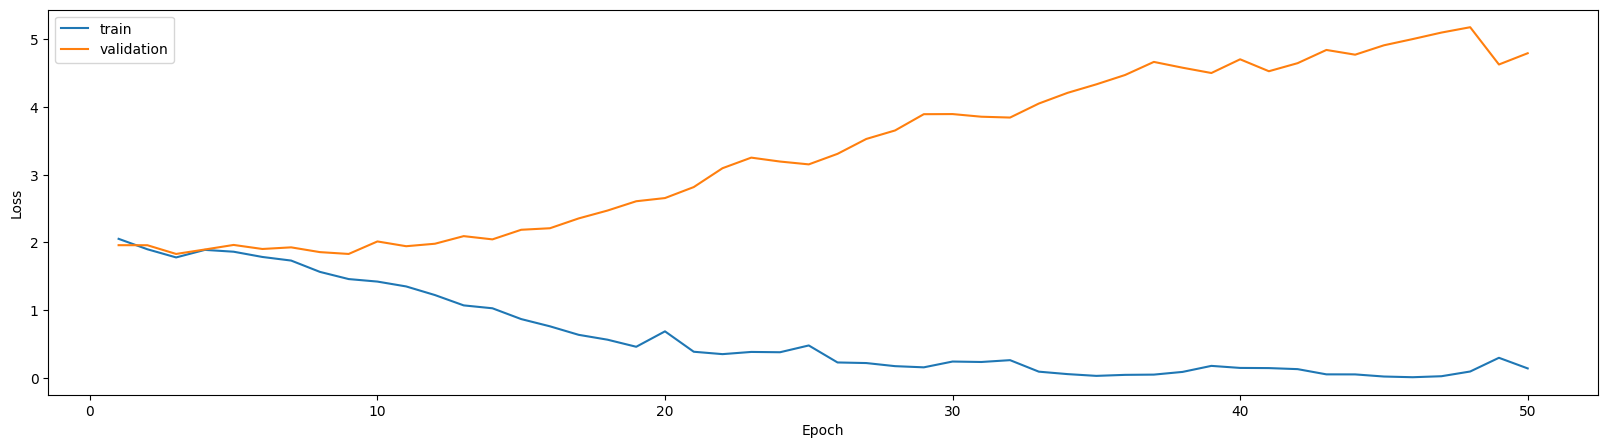

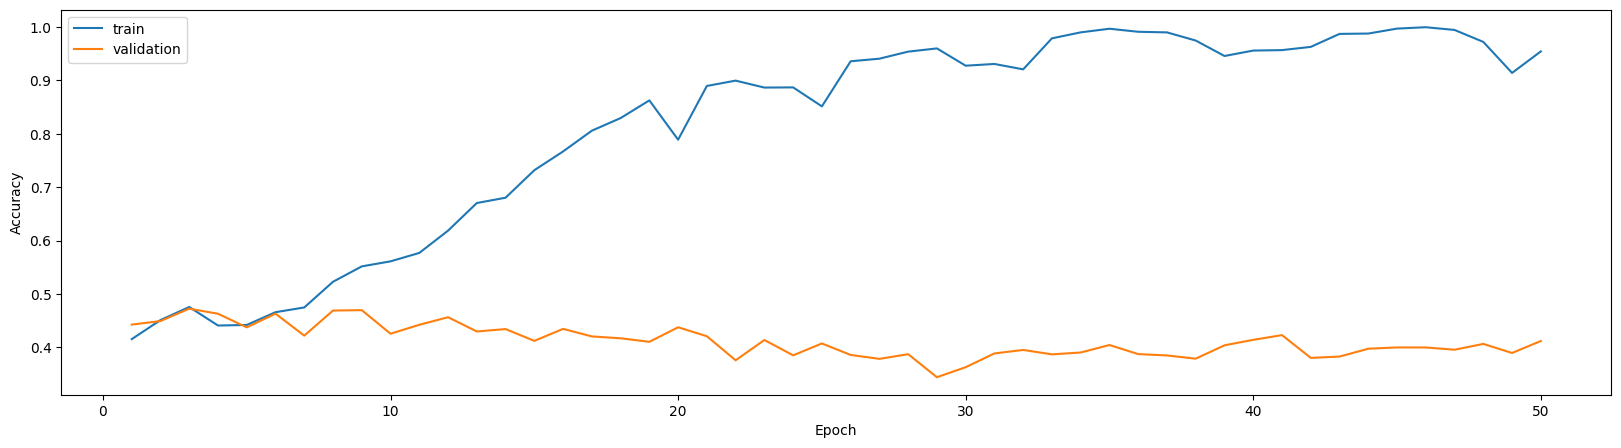

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

	Evaluation: 100%|██████████| 193/193 [00:02<00:00, 88.14it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Loss: 1.817 | Test Acc: 47.87% | Test F1: 0.382 | Test ROC AUC: 0.713

Classification report:
              precision    recall  f1-score   support

           0       0.47      0.87      0.61      4983
           1       0.35      0.36      0.36       672
           2       0.21      0.01      0.02      1070
           3       0.27      0.04      0.08       667
           4       0.12      0.05      0.07       837
           5       0.40      0.03      0.05       144
           6       0.20      0.01      0.01       351
           7       0.35      0.19      0.24       551
           8       0.00      0.00      0.00       200
           9       0.53      0.63      0.58       614
          10       0.00      0.00      0.00       570
          11       0.00      0.00      0.00       208
          12       0.92      0.82      0.87       844
          13       0.34      0.07      0.11       629

    accuracy                           0.48     12340
   macro avg       0.30      0.22 

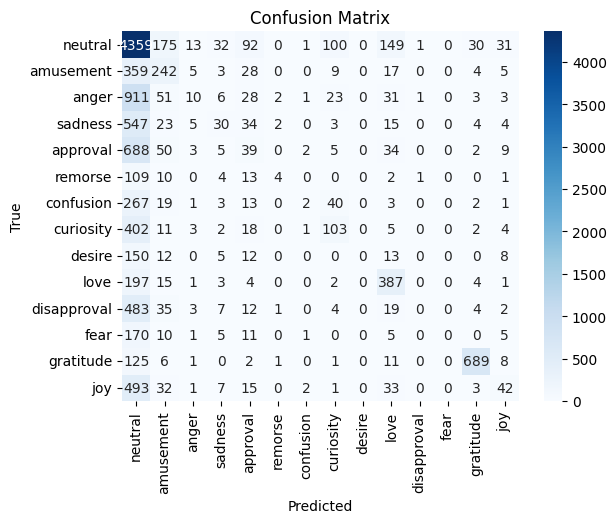

In [ ]:
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('baseline-model.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



--------------------------------

--------------------------------
-------


## Class Imbalance
First, undersampling will be used to fix class imbalance where neutral class is not as dominant.

In [ ]:
# load the customized dataset with chosen labels
text = torch.load("/content/drive/MyDrive/Colab Notebooks/NLP CW/preprocessed_data_1.pt")
data = to_map_style_dataset(text)
train_data[0]

['[NAME] had more of a Pro Bowl season than [NAME].', 0]

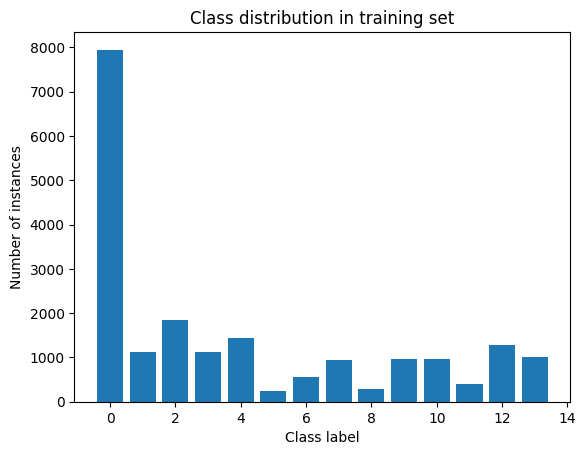

In [ ]:
# Used chatGPT to generate plotting code and adjusted/debugged

import matplotlib.pyplot as plt
import numpy as np

# Extract labels from train_data
labels = [example[1] for example in train_data]

# Compute class distribution
unique_labels, counts = np.unique(labels, return_counts=True)
class_dist = dict(zip(unique_labels, counts))

# Plot class distribution
fig, ax = plt.subplots()
ax.bar(class_dist.keys(), class_dist.values())
ax.set_xlabel('Class label')
ax.set_ylabel('Number of instances')
ax.set_title('Class distribution in training set')
plt.show()


In [ ]:
import random

# Define the number of samples to select
num_samples = 2000

# Create a list to hold the selected samples
selected_samples = []

# Loop through the train_data and select the desired number of class 0 samples
for text, label in train_data:
    if label == 0:
        # Add the sample to the selected_samples list
        selected_samples.append((text, label))
        # If we've selected the desired number of class 0 samples, break out of the loop
        if len(selected_samples) == num_samples:
            break

# Combine the selected class 0 samples with the remaining samples
remaining_samples = [(text, label) for text, label in train_data if label != 0]
new_train_data = selected_samples + remaining_samples

# Shuffle the new_train_data to ensure that the class 0 samples are distributed randomly throughout the dataset
random.shuffle(new_train_data)
train_data = new_train_data

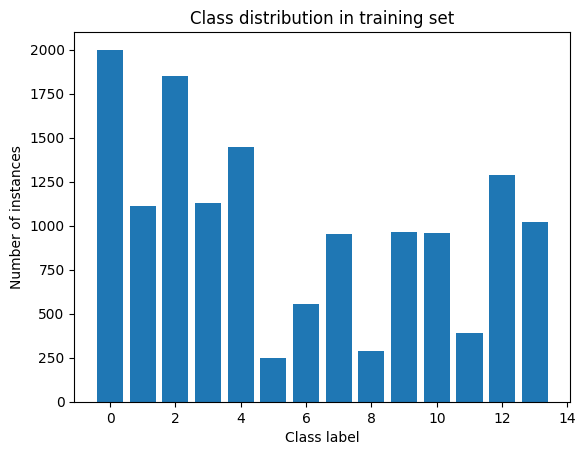

In [ ]:
# Used chatGPT to generate plotting code and adjusted/debugged

import matplotlib.pyplot as plt
import numpy as np

# Extract labels from train_data
labels = [example[1] for example in train_data]

# Compute class distribution
unique_labels, counts = np.unique(labels, return_counts=True)
class_dist = dict(zip(unique_labels, counts))

# Plot class distribution
fig, ax = plt.subplots()
ax.bar(class_dist.keys(), class_dist.values())
ax.set_xlabel('Class label')
ax.set_ylabel('Number of instances')
ax.set_title('Class distribution in training set')
plt.show()

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, vocab
from collections import OrderedDict

import torchtext.transforms as T

# defining a tokenizer as a PyTorch module
class SpacyTokenizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

    def forward(self, input):
        if isinstance(input, list):
            tokens = []
            for text in input:
                tokens.append(self.tokenizer(text))
            return tokens
        elif isinstance(input, str):
            return self.tokenizer(input)
        raise ValueError(f"Type {type(input)} is not supported.")

# defining auxilary functions for tokenizing

tokenizer = SpacyTokenizer()
MAX_VOCAB_SIZE = 25_000

def _process_texts_for_vocab(data):
    for line in data:
        yield tokenizer(line[0])

def _get_labels_for_vocab(data):
    for line in data:
        yield [line[1]]

# defining a function to transform each text into its length
class ToLengths(torch.nn.Module):
    def forward(self, input):
        if isinstance(input[1], list):    # changed to match the order in dataset
            lengths = []
            for text in input:
                lengths.append(len(text))
            return lengths
        elif isinstance(input, list):
            return len(input)
        raise ValueError(f"Type {type(input)} is not supported.")

In [ ]:
# tokenizing text and label vocabs
text_vocab = build_vocab_from_iterator(_process_texts_for_vocab(train_data), specials=('<unk>', '<pad>'), max_tokens=MAX_VOCAB_SIZE)
label_vocab = vocab(OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)]))
text_vocab.set_default_index(text_vocab["<unk>"])

In [ ]:
# check the tokens in text and label vocabulary
print(f"Unique tokens in text vocabulary: {len(text_vocab)}")
print(f"Unique tokens in label vocabulary: {len(label_vocab)}")

Unique tokens in text vocabulary: 17723
Unique tokens in label vocabulary: 14


In [ ]:
# convert texts, labels, and lengths into tensors appropriately

text_transform = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    T.ToTensor(),  # Convert to tensor
)

lengths_transform = T.Sequential(
    SpacyTokenizer(),   # tokenize
    ToLengths(),    # convert to lengths
    T.ToTensor(),   # convert to tensor
)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

def collate_batch(batch):
    texts, labels = zip(*batch)

    lengths = lengths_transform(list(texts))
    texts = text_transform(list(texts))
    labels = torch.tensor(list(labels), dtype=torch.int64)

    return labels.to(DEVICE), texts.to(DEVICE), lengths.cpu()


def _get_dataloader(data):
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)


In [ ]:
train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

---
### Functions required for training and evaluation
---

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
import time

# defining a function for training the model
# Taken from lab but changed to be used for multi-class classification training instead of binary classification

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in tqdm(iterator, desc="\tTraining"):
        optimizer.zero_grad()

        labels, texts, lengths = batch  # Note that this has to match the order in collate_batch
        predictions = model(texts, lengths)
        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Defining a function to evaluate using the trained model (on either validation or test sets)
# Taken from lab 5 but changed to be used for multi-class classification evaluation instead of binary classification
# Further modified to return metrics like F1 score, confusion matrix, and classification report to check scores for each class
# ChatGPT was used for debugging aur_roc code

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    predicted_probs = []
    true_labels = []

    model.eval()

    with torch.no_grad():
        for batch in tqdm(iterator, desc="\tEvaluation"):
            labels, texts, lengths = batch  # Note that this has to match the order in collate_batch
            predictions = model(texts, lengths)
            probs = torch.softmax(predictions, dim=1)
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            predicted_probs.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predicted_probs = np.array(predicted_probs)
    true_labels = np.array(true_labels)
    predicted_labels = np.argmax(predicted_probs, axis=1)

    epoch_f1 = f1_score(true_labels, predicted_labels, average='weighted')
    epoch_auc_roc = roc_auc_score(true_labels, predicted_probs, multi_class='ovo', average='weighted')
    epoch_classification_report = classification_report(true_labels, predicted_labels)
    epoch_confusion_matrix = confusion_matrix(true_labels, predicted_labels)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1, epoch_auc_roc, epoch_classification_report, epoch_confusion_matrix


# defining a function to check duration taken for training and testing
# taken from lab 5

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


#defining a function to check number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# defining a categorical accuracy function instead of binary accuracy
# ChatGPT was used to find this piece of code and further debugging was required to make it work as expected

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc



---

### Model Building

---



In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM) # create a RNN model using the arguments
print(f'The model has {count_parameters(model):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 1,867,546 trainable parameters


In [ ]:
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'balanced-baseline-model.pt')

Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 222/222 [00:05<00:00, 41.36it/s]


	Train Loss: 2.306 | Train Acc: 22.66%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 52.61it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.102 |  Val. Acc: 23.83%
Epoch: 02


	Training: 100%|██████████| 222/222 [00:02<00:00, 96.99it/s]


	Train Loss: 2.202 | Train Acc: 27.78%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.34it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.211 |  Val. Acc: 32.11%
Epoch: 03


	Training: 100%|██████████| 222/222 [00:02<00:00, 96.39it/s]


	Train Loss: 2.127 | Train Acc: 29.91%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.78it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.211 |  Val. Acc: 22.32%
Epoch: 04


	Training: 100%|██████████| 222/222 [00:02<00:00, 95.94it/s]


	Train Loss: 2.049 | Train Acc: 33.04%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 102.45it/s]


	 Val. Loss: 2.202 |  Val. Acc: 22.82%
Epoch: 05


	Training: 100%|██████████| 222/222 [00:03<00:00, 67.26it/s]


	Train Loss: 1.906 | Train Acc: 37.55%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 110.88it/s]


	 Val. Loss: 2.133 |  Val. Acc: 28.86%
Epoch: 06


	Training: 100%|██████████| 222/222 [00:03<00:00, 70.37it/s]


	Train Loss: 1.801 | Train Acc: 41.92%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.87it/s]


	 Val. Loss: 2.236 |  Val. Acc: 25.47%
Epoch: 07


	Training: 100%|██████████| 222/222 [00:02<00:00, 91.79it/s]


	Train Loss: 1.711 | Train Acc: 44.75%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.12it/s]


	 Val. Loss: 2.202 |  Val. Acc: 27.50%
Epoch: 08


	Training: 100%|██████████| 222/222 [00:02<00:00, 82.00it/s]


	Train Loss: 1.538 | Train Acc: 50.46%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 92.01it/s]


	 Val. Loss: 2.233 |  Val. Acc: 27.97%
Epoch: 09


	Training: 100%|██████████| 222/222 [00:02<00:00, 74.94it/s]


	Train Loss: 1.383 | Train Acc: 55.82%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.03it/s]


	 Val. Loss: 2.146 |  Val. Acc: 33.17%
Epoch: 10


	Training: 100%|██████████| 222/222 [00:02<00:00, 98.02it/s]


	Train Loss: 1.218 | Train Acc: 61.93%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.19it/s]


	 Val. Loss: 2.315 |  Val. Acc: 30.49%
Epoch: 11


	Training: 100%|██████████| 222/222 [00:02<00:00, 96.50it/s]


	Train Loss: 1.029 | Train Acc: 67.64%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.49it/s]


	 Val. Loss: 2.501 |  Val. Acc: 27.73%
Epoch: 12


	Training: 100%|██████████| 222/222 [00:02<00:00, 78.11it/s]


	Train Loss: 0.877 | Train Acc: 73.06%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 92.60it/s]


	 Val. Loss: 2.688 |  Val. Acc: 29.06%
Epoch: 13


	Training: 100%|██████████| 222/222 [00:02<00:00, 79.14it/s]


	Train Loss: 0.744 | Train Acc: 77.72%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.61it/s]


	 Val. Loss: 2.900 |  Val. Acc: 26.25%
Epoch: 14


	Training: 100%|██████████| 222/222 [00:02<00:00, 97.50it/s]


	Train Loss: 0.833 | Train Acc: 74.60%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.23it/s]


	 Val. Loss: 2.842 |  Val. Acc: 30.02%
Epoch: 15


	Training: 100%|██████████| 222/222 [00:02<00:00, 92.44it/s]


	Train Loss: 0.523 | Train Acc: 84.98%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.48it/s]


	 Val. Loss: 3.143 |  Val. Acc: 29.03%
Epoch: 16


	Training: 100%|██████████| 222/222 [00:03<00:00, 72.84it/s]


	Train Loss: 0.361 | Train Acc: 90.45%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.58it/s]


	 Val. Loss: 3.441 |  Val. Acc: 29.25%
Epoch: 17


	Training: 100%|██████████| 222/222 [00:02<00:00, 85.01it/s]


	Train Loss: 0.338 | Train Acc: 90.67%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.45it/s]


	 Val. Loss: 3.583 |  Val. Acc: 29.83%
Epoch: 18


	Training: 100%|██████████| 222/222 [00:02<00:00, 94.43it/s]


	Train Loss: 0.193 | Train Acc: 95.47%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.33it/s]


	 Val. Loss: 3.827 |  Val. Acc: 29.02%
Epoch: 19


	Training: 100%|██████████| 222/222 [00:02<00:00, 95.79it/s]


	Train Loss: 0.114 | Train Acc: 97.95%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.40it/s]


	 Val. Loss: 4.113 |  Val. Acc: 27.43%
Epoch: 20


	Training: 100%|██████████| 222/222 [00:03<00:00, 69.72it/s]


	Train Loss: 0.221 | Train Acc: 94.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.37it/s]


	 Val. Loss: 4.034 |  Val. Acc: 29.46%
Epoch: 21


	Training: 100%|██████████| 222/222 [00:02<00:00, 92.95it/s]


	Train Loss: 0.344 | Train Acc: 89.57%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.83it/s]


	 Val. Loss: 4.123 |  Val. Acc: 28.73%
Epoch: 22


	Training: 100%|██████████| 222/222 [00:02<00:00, 75.26it/s]


	Train Loss: 0.149 | Train Acc: 96.37%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.20it/s]


	 Val. Loss: 4.426 |  Val. Acc: 27.91%
Epoch: 23


	Training: 100%|██████████| 222/222 [00:02<00:00, 96.68it/s]


	Train Loss: 0.106 | Train Acc: 97.70%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 98.25it/s]


	 Val. Loss: 4.541 |  Val. Acc: 28.94%
Epoch: 24


	Training: 100%|██████████| 222/222 [00:03<00:00, 66.57it/s]


	Train Loss: 0.049 | Train Acc: 99.22%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 119.62it/s]


	 Val. Loss: 4.735 |  Val. Acc: 28.16%
Epoch: 25


	Training: 100%|██████████| 222/222 [00:02<00:00, 98.46it/s]


	Train Loss: 0.039 | Train Acc: 99.52%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.01it/s]


	 Val. Loss: 4.815 |  Val. Acc: 29.23%
Epoch: 26


	Training: 100%|██████████| 222/222 [00:02<00:00, 97.13it/s]


	Train Loss: 0.013 | Train Acc: 99.97%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.48it/s]


	 Val. Loss: 4.941 |  Val. Acc: 29.16%
Epoch: 27


	Training: 100%|██████████| 222/222 [00:02<00:00, 96.46it/s]


	Train Loss: 0.008 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.70it/s]


	 Val. Loss: 5.042 |  Val. Acc: 29.33%
Epoch: 28


	Training: 100%|██████████| 222/222 [00:03<00:00, 67.07it/s]


	Train Loss: 0.007 | Train Acc: 99.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.96it/s]


	 Val. Loss: 5.129 |  Val. Acc: 29.36%
Epoch: 29


	Training: 100%|██████████| 222/222 [00:02<00:00, 96.15it/s]


	Train Loss: 0.005 | Train Acc: 99.99%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.44it/s]


	 Val. Loss: 5.237 |  Val. Acc: 29.28%
Epoch: 30


	Training: 100%|██████████| 222/222 [00:02<00:00, 96.50it/s]


	Train Loss: 0.004 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.35it/s]


	 Val. Loss: 5.301 |  Val. Acc: 29.41%
Epoch: 31


	Training: 100%|██████████| 222/222 [00:02<00:00, 92.65it/s]


	Train Loss: 0.003 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.44it/s]


	 Val. Loss: 5.376 |  Val. Acc: 29.43%
Epoch: 32


	Training: 100%|██████████| 222/222 [00:03<00:00, 68.33it/s]


	Train Loss: 0.003 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.79it/s]


	 Val. Loss: 5.424 |  Val. Acc: 29.71%
Epoch: 33


	Training: 100%|██████████| 222/222 [00:02<00:00, 95.06it/s]


	Train Loss: 0.002 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.38it/s]


	 Val. Loss: 5.520 |  Val. Acc: 29.66%
Epoch: 34


	Training: 100%|██████████| 222/222 [00:02<00:00, 97.92it/s]


	Train Loss: 0.002 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.73it/s]


	 Val. Loss: 5.579 |  Val. Acc: 29.65%
Epoch: 35


	Training: 100%|██████████| 222/222 [00:02<00:00, 88.22it/s]


	Train Loss: 0.002 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.06it/s]


	 Val. Loss: 5.650 |  Val. Acc: 29.66%
Epoch: 36


	Training: 100%|██████████| 222/222 [00:03<00:00, 69.06it/s]


	Train Loss: 0.001 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.27it/s]


	 Val. Loss: 5.715 |  Val. Acc: 29.67%
Epoch: 37


	Training: 100%|██████████| 222/222 [00:02<00:00, 94.36it/s]


	Train Loss: 0.001 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.00it/s]


	 Val. Loss: 5.773 |  Val. Acc: 29.72%
Epoch: 38


	Training: 100%|██████████| 222/222 [00:02<00:00, 94.88it/s]


	Train Loss: 0.001 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.07it/s]


	 Val. Loss: 5.830 |  Val. Acc: 29.67%
Epoch: 39


	Training: 100%|██████████| 222/222 [00:02<00:00, 82.52it/s]


	Train Loss: 0.001 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.05it/s]


	 Val. Loss: 5.896 |  Val. Acc: 29.58%
Epoch: 40


	Training: 100%|██████████| 222/222 [00:02<00:00, 75.13it/s]


	Train Loss: 0.001 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.90it/s]


	 Val. Loss: 5.952 |  Val. Acc: 29.65%
Epoch: 41


	Training: 100%|██████████| 222/222 [00:02<00:00, 96.30it/s]


	Train Loss: 0.001 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.77it/s]


	 Val. Loss: 5.993 |  Val. Acc: 29.85%
Epoch: 42


	Training: 100%|██████████| 222/222 [00:02<00:00, 95.88it/s]


	Train Loss: 0.001 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.96it/s]


	 Val. Loss: 6.070 |  Val. Acc: 29.69%
Epoch: 43


	Training: 100%|██████████| 222/222 [00:02<00:00, 77.74it/s]


	Train Loss: 0.001 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.44it/s]


	 Val. Loss: 6.136 |  Val. Acc: 29.83%
Epoch: 44


	Training: 100%|██████████| 222/222 [00:02<00:00, 79.01it/s]


	Train Loss: 0.001 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.74it/s]


	 Val. Loss: 6.188 |  Val. Acc: 29.79%
Epoch: 45


	Training: 100%|██████████| 222/222 [00:02<00:00, 95.62it/s]


	Train Loss: 0.000 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.59it/s]


	 Val. Loss: 6.249 |  Val. Acc: 29.75%
Epoch: 46


	Training: 100%|██████████| 222/222 [00:02<00:00, 96.64it/s]


	Train Loss: 0.000 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.28it/s]


	 Val. Loss: 6.321 |  Val. Acc: 29.74%
Epoch: 47


	Training: 100%|██████████| 222/222 [00:03<00:00, 71.26it/s]


	Train Loss: 0.000 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.50it/s]


	 Val. Loss: 6.371 |  Val. Acc: 29.78%
Epoch: 48


	Training: 100%|██████████| 222/222 [00:02<00:00, 84.04it/s]


	Train Loss: 0.000 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.01it/s]


	 Val. Loss: 6.418 |  Val. Acc: 29.86%
Epoch: 49


	Training: 100%|██████████| 222/222 [00:03<00:00, 63.66it/s]


	Train Loss: 0.000 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.41it/s]


	 Val. Loss: 6.482 |  Val. Acc: 29.82%
Epoch: 50


	Training: 100%|██████████| 222/222 [00:02<00:00, 97.83it/s]


	Train Loss: 0.000 | Train Acc: 100.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 99.46it/s]


	 Val. Loss: 6.528 |  Val. Acc: 29.82%


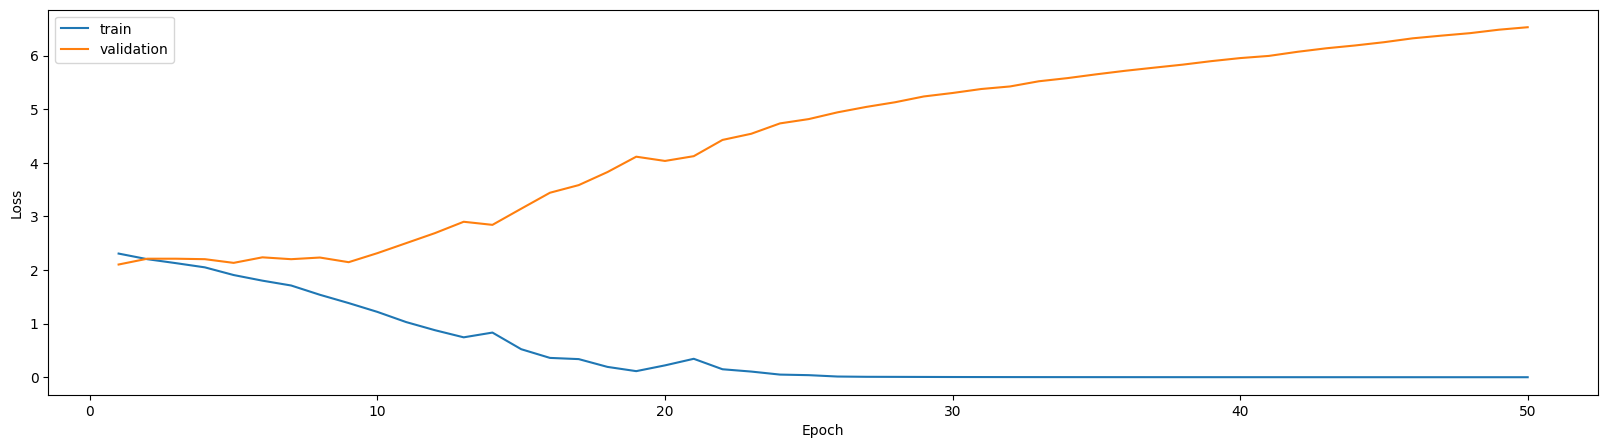

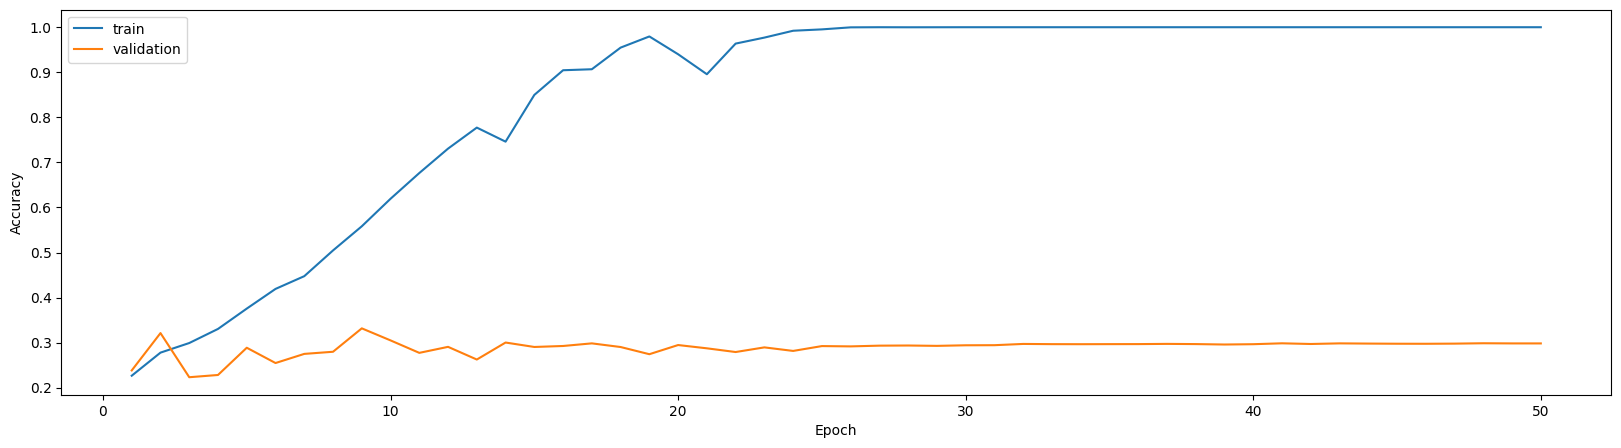

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

	Evaluation: 100%|██████████| 193/193 [00:03<00:00, 53.25it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Loss: 2.095 | Test Acc: 24.07% | Test F1: 0.217 | Test ROC AUC: 0.676

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.13      0.20      4983
           1       0.30      0.34      0.31       672
           2       0.10      0.60      0.18      1070
           3       0.17      0.07      0.10       667
           4       0.13      0.08      0.10       837
           5       0.40      0.01      0.03       144
           6       0.00      0.00      0.00       351
           7       0.36      0.56      0.44       551
           8       0.00      0.00      0.00       200
           9       0.46      0.59      0.52       614
          10       0.02      0.00      0.00       570
          11       0.00      0.00      0.00       208
          12       0.44      0.74      0.55       844
          13       0.22      0.09      0.13       629

    accuracy                           0.24     12340
   macro avg       0.22      0.23 

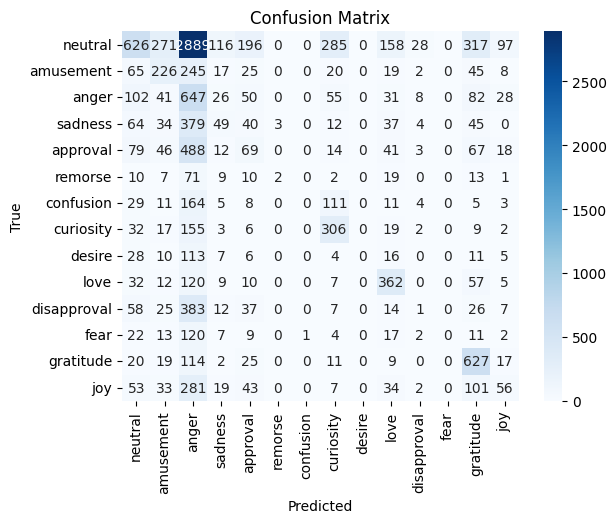

In [ ]:
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('balanced-baseline-model.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

The test accuracy, test F1 score, and test ROC AUC all go down after using undersampled data. This is again due to the high proportion of neutral lablled data. Since the number of training samples for 'neutral' and 'anger' were similar and higher than the rest of the labels, the model now predicts the majority of test data as 'anger' hoping to be correct.<br>
The F1 score for some individual classes may have risen but since the overall score is lower, we can conclude that **Undersampling does not increase the overall performance of an RNN.**



---



---



---



## Stemming / Lematization / other preprocessing

In [ ]:
# load the customized dataset with chosen labels
text = torch.load("preprocessed_data_1.pt")
data = to_map_style_dataset(text)
train_data[0]

('wait look s', 7)

In [ ]:
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

def remove_stopwords(text):
    stop_words = sklearn_stop_words
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def stem_text(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def preprocess_text(text):
    # text = text.lower() # convert to lowercase
    # text = re.sub(r'\d+', '', text) # remove numbers
    # text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    # text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    # text = text.strip() # remove leading/trailing whitespace
    text = remove_stopwords(text) # remove stopwords
    text = stem_text(text) # perform stemming
    text = lemmatize_text(text) # perform lemmatization
    return text

def preprocess_data(data):
    preprocessed_data = []
    for sentence, label in data:
        preprocessed_sentence = preprocess_text(sentence)
        if len(preprocessed_sentence) > 0:
            preprocessed_data.append((preprocessed_sentence, label))
    return preprocessed_data

train_data = preprocess_data(train_data)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# tokenizing text and label vocabs
text_vocab = build_vocab_from_iterator(_process_texts_for_vocab(train_data), specials=('<unk>', '<pad>'), max_tokens=MAX_VOCAB_SIZE)
label_vocab = vocab(OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)]))
text_vocab.set_default_index(text_vocab["<unk>"])

In [ ]:
# view most frequent words in the vocabulary

from collections import Counter

counter = Counter()
for (line, label) in train_data:
    counter.update(tokenizer(line))

counter.most_common(20)

[('nt', 3001),
 ('i', 2184),
 ('just', 1731),
 ('like', 1715),
 ('m', 1596),
 ('do', 1222),
 ('thank', 1034),
 ('love', 977),
 ('did', 900),
 ('peopl', 882),
 ('make', 846),
 ('think', 830),
 ('good', 787),
 ('know', 772),
 ('look', 743),
 ('realli', 718),
 ('time', 685),
 ('want', 607),
 ('say', 556),
 ('thing', 547)]

In [ ]:
# convert texts, labels, and lengths into tensors appropriately

text_transform = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    # T.LabelToIndex(label_vocab.get_itos()),  # Convert to integer #labels are already integers
    T.ToTensor(),  # Convert to tensor
)

lengths_transform = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)

train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

In [ ]:
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab)

model_ppdata = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

#####
# import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

model_ppdata = model_ppdata.to(DEVICE)
criterion = criterion.to(DEVICE)
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model_ppdata, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model_ppdata, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_ppdata.state_dict(), 'model-on-pp-data.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 343/343 [00:03<00:00, 106.07it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:03<00:00, 42.25it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 02


	Training: 100%|██████████| 343/343 [00:02<00:00, 158.23it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 127.85it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.03%
Epoch: 03


	Training: 100%|██████████| 343/343 [00:02<00:00, 166.25it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 131.61it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 04


	Training: 100%|██████████| 343/343 [00:02<00:00, 165.73it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 129.94it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 05


	Training: 100%|██████████| 343/343 [00:02<00:00, 114.49it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 103.08it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 06


	Training: 100%|██████████| 343/343 [00:02<00:00, 166.12it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 126.41it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 07


	Training: 100%|██████████| 343/343 [00:02<00:00, 167.05it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 128.24it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 08


	Training: 100%|██████████| 343/343 [00:02<00:00, 159.61it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 94.08it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 09


	Training: 100%|██████████| 343/343 [00:02<00:00, 122.31it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 128.44it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 10


	Training: 100%|██████████| 343/343 [00:02<00:00, 163.05it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 125.56it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 11


	Training: 100%|██████████| 343/343 [00:02<00:00, 165.24it/s]


	Train Loss: 2.698 | Train Acc: 4.66%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 131.41it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 12


	Training: 100%|██████████| 343/343 [00:02<00:00, 144.67it/s]


	Train Loss: 2.697 | Train Acc: 4.66%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 83.72it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 13


	Training: 100%|██████████| 343/343 [00:02<00:00, 148.31it/s]


	Train Loss: 2.697 | Train Acc: 4.66%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 131.39it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.03%
Epoch: 14


	Training: 100%|██████████| 343/343 [00:02<00:00, 169.23it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 133.14it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 15


	Training: 100%|██████████| 343/343 [00:02<00:00, 167.52it/s]


	Train Loss: 2.697 | Train Acc: 4.66%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 128.72it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 16


	Training: 100%|██████████| 343/343 [00:02<00:00, 122.02it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 84.16it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 17


	Training: 100%|██████████| 343/343 [00:02<00:00, 169.92it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 132.02it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 18


	Training: 100%|██████████| 343/343 [00:02<00:00, 166.60it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 127.35it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 19


	Training: 100%|██████████| 343/343 [00:02<00:00, 164.98it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 112.99it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.03%
Epoch: 20


	Training: 100%|██████████| 343/343 [00:03<00:00, 113.13it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 118.55it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.01%
Epoch: 21


	Training: 100%|██████████| 343/343 [00:02<00:00, 168.06it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 130.13it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 22


	Training: 100%|██████████| 343/343 [00:02<00:00, 167.16it/s]


	Train Loss: 2.697 | Train Acc: 4.68%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 131.11it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 23


	Training: 100%|██████████| 343/343 [00:02<00:00, 166.92it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 85.37it/s]


	 Val. Loss: 2.683 |  Val. Acc: 5.02%
Epoch: 24


	Training: 100%|██████████| 343/343 [00:02<00:00, 125.35it/s]


	Train Loss: 2.698 | Train Acc: 4.66%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 132.79it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 25


	Training: 100%|██████████| 343/343 [00:02<00:00, 170.16it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 133.36it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.03%
Epoch: 26


	Training: 100%|██████████| 343/343 [00:02<00:00, 167.78it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 130.12it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 27


	Training: 100%|██████████| 343/343 [00:02<00:00, 140.57it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 83.10it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 28


	Training: 100%|██████████| 343/343 [00:02<00:00, 149.53it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 126.61it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 29


	Training: 100%|██████████| 343/343 [00:02<00:00, 162.96it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 130.00it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 30


	Training: 100%|██████████| 343/343 [00:02<00:00, 169.29it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 132.87it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 31


	Training: 100%|██████████| 343/343 [00:02<00:00, 118.26it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 93.28it/s] 


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 32


	Training: 100%|██████████| 343/343 [00:02<00:00, 161.05it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 127.42it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 33


	Training: 100%|██████████| 343/343 [00:02<00:00, 167.82it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 126.05it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 34


	Training: 100%|██████████| 343/343 [00:02<00:00, 167.21it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 95.19it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 35


	Training: 100%|██████████| 343/343 [00:02<00:00, 114.37it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 124.70it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 36


	Training: 100%|██████████| 343/343 [00:02<00:00, 167.85it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 130.10it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 37


	Training: 100%|██████████| 343/343 [00:02<00:00, 166.13it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 130.73it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 38


	Training: 100%|██████████| 343/343 [00:02<00:00, 147.08it/s]


	Train Loss: 2.698 | Train Acc: 4.66%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 87.99it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 39


	Training: 100%|██████████| 343/343 [00:02<00:00, 140.00it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 128.65it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 40


	Training: 100%|██████████| 343/343 [00:02<00:00, 161.23it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 130.47it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 41


	Training: 100%|██████████| 343/343 [00:02<00:00, 164.63it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 127.57it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 42


	Training: 100%|██████████| 343/343 [00:02<00:00, 123.40it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 85.13it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 43


	Training: 100%|██████████| 343/343 [00:02<00:00, 163.21it/s]


	Train Loss: 2.697 | Train Acc: 4.66%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 127.59it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 44


	Training: 100%|██████████| 343/343 [00:02<00:00, 167.02it/s]


	Train Loss: 2.697 | Train Acc: 4.66%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 130.04it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 45


	Training: 100%|██████████| 343/343 [00:02<00:00, 164.94it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 112.74it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 46


	Training: 100%|██████████| 343/343 [00:02<00:00, 114.59it/s]


	Train Loss: 2.698 | Train Acc: 4.66%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 124.34it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.01%
Epoch: 47


	Training: 100%|██████████| 343/343 [00:02<00:00, 167.85it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 128.96it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.03%
Epoch: 48


	Training: 100%|██████████| 343/343 [00:02<00:00, 161.26it/s]


	Train Loss: 2.697 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 125.07it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 49


	Training: 100%|██████████| 343/343 [00:02<00:00, 155.53it/s]


	Train Loss: 2.698 | Train Acc: 4.67%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 83.32it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%
Epoch: 50


	Training: 100%|██████████| 343/343 [00:02<00:00, 133.31it/s]


	Train Loss: 2.697 | Train Acc: 4.68%


	Evaluation: 100%|██████████| 148/148 [00:01<00:00, 129.40it/s]


	 Val. Loss: 2.684 |  Val. Acc: 5.02%


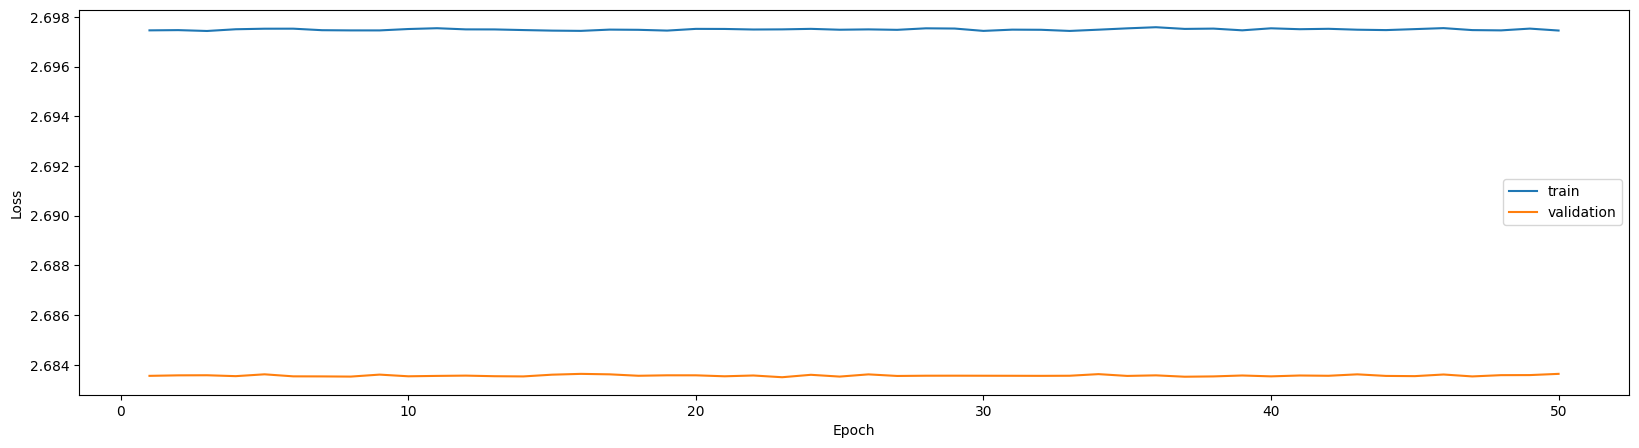

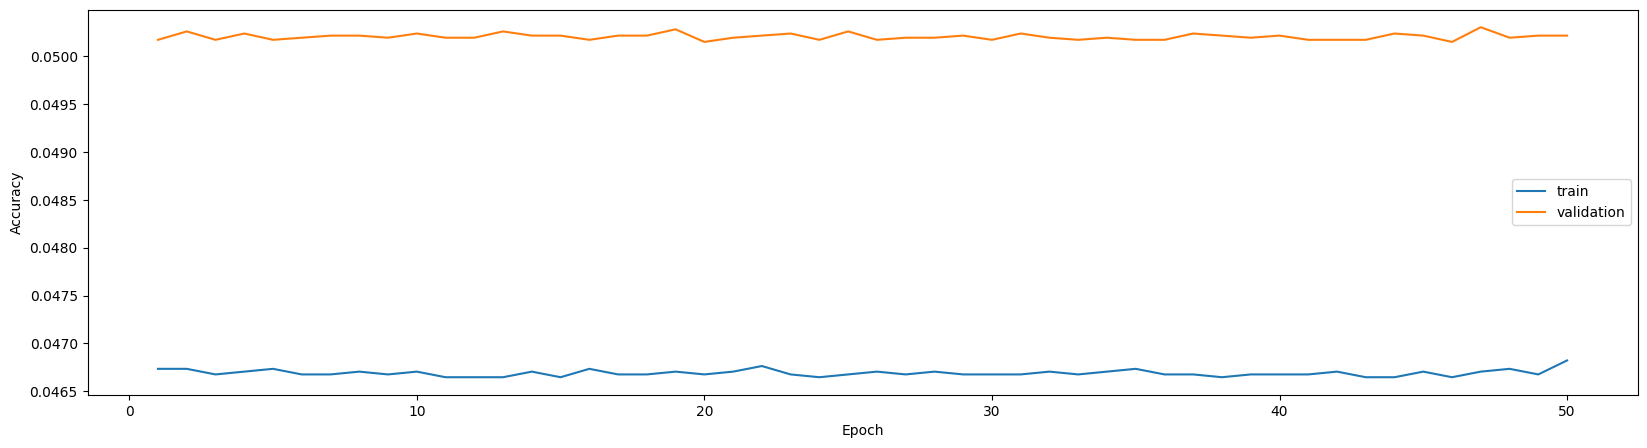

	Evaluation: 100%|██████████| 212/212 [00:02<00:00, 76.33it/s]



Test Loss: 2.679 | Test Acc: 5.01% | Test F1: 0.022 | Test ROC AUC: 0.507

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.00      0.00      4770
           1       0.04      0.02      0.03       633
           2       0.09      0.01      0.02      1112
           3       0.05      0.33      0.09       683
           4       0.12      0.01      0.02      1267
           5       0.02      0.06      0.03       366
           6       0.03      0.03      0.03       300
           7       0.04      0.01      0.02       770
           8       0.01      0.01      0.01       146
           9       0.07      0.00      0.01      1517
          10       0.02      0.00      0.00       530
          11       0.01      0.01      0.01       197
          12       0.06      0.40      0.10       742
          13       0.04      0.13      0.06       483

    accuracy                           0.05     13516
   macro avg       0.07      0.07  

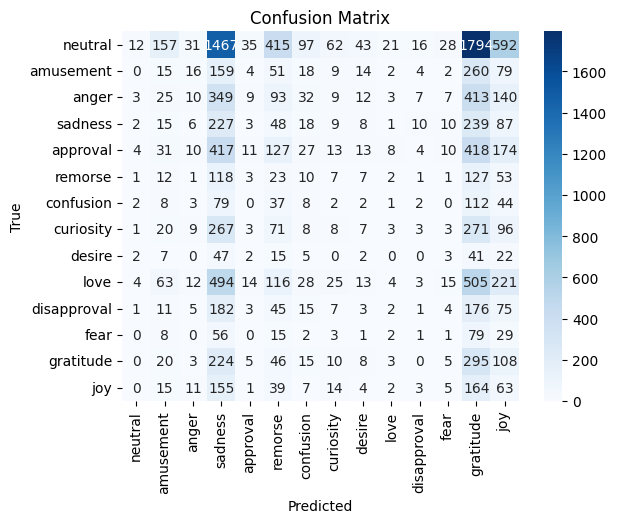

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model_ppdata.load_state_dict(torch.load('model-on-pp-data.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model_ppdata, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

After performing stemming, lemmatization, stop-words removal, and several other text processing steps, the accuracy significantly drops. This may be because the pre-trained vectors used to build vocabularies may not be trained on stemmed/lemmatized data. Also, these steps are only performed on the training data which makes it look very different to a real world user input (test data).

**Thus, these steps negatively impacted the accuracy and are not required for future experiments**



---





---



---



## Vocabulary Size variation

In [ ]:
# defining auxilary functions for tokenizing

tokenizer = SpacyTokenizer()
MAX_VOCAB_SIZE = 100_000

def _process_texts_for_vocab(data):
    for line in data:
        yield tokenizer(line[0])

def _get_labels_for_vocab(data):
    for line in data:
        yield [line[1]]

In [ ]:
# tokenizing text and label vocabs
text_vocab = build_vocab_from_iterator(_process_texts_for_vocab(train_data), specials=('<unk>', '<pad>'), max_tokens=MAX_VOCAB_SIZE)
label_vocab = vocab(OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)]))
text_vocab.set_default_index(text_vocab["<unk>"])

In [ ]:
# check the tokens in text and label vocabulary
print(f"Unique tokens in text vocabulary: {len(text_vocab)}")
print(f"Unique tokens in label vocabulary: {len(label_vocab)}")

Unique tokens in text vocabulary: 23881
Unique tokens in label vocabulary: 14


In [ ]:
unique_tokens = set()
for sentence, label in data:
    unique_tokens.update(tokenizer(sentence))
print(f"Number of unique tokens in training data: {len(unique_tokens)}")


Number of unique tokens in training data: 35522


### Unique tokens are already less than 25k. Increasing vocab size does not make a difference.

---
---
---
